## Baseline-baised margin

/home/iai/son/heo_jun/RF_new/recipe1/rf_module
Random State가  1  일 때  Baseline model:  0.7166421888598782
Random State가  1  일 때  Advance model:  0.731744253896669
Random State가  2  일 때  Baseline model:  0.6846862884721893
Random State가  2  일 때  Advance model:  0.7112076212516814
Random State가  3  일 때  Baseline model:  0.7398256388954823
Random State가  3  일 때  Advance model:  0.7537359561674183
Random State가  4  일 때  Baseline model:  0.7009405411820555
Random State가  4  일 때  Advance model:  0.6938469222248596
Random State가  5  일 때  Baseline model:  0.6791540568874119
Random State가  5  일 때  Advance model:  0.7368388519661366
Random State가  6  일 때  Baseline model:  0.7095634049370994
Random State가  6  일 때  Advance model:  0.7744382466967323
Random State가  7  일 때  Baseline model:  0.7215402227233167
Random State가  7  일 때  Advance model:  0.7496526129440619
Random State가  8  일 때  Baseline model:  0.7248818142258089
Random State가  8  일 때  Advance model:  0.7355049351214495
Random State가  9  

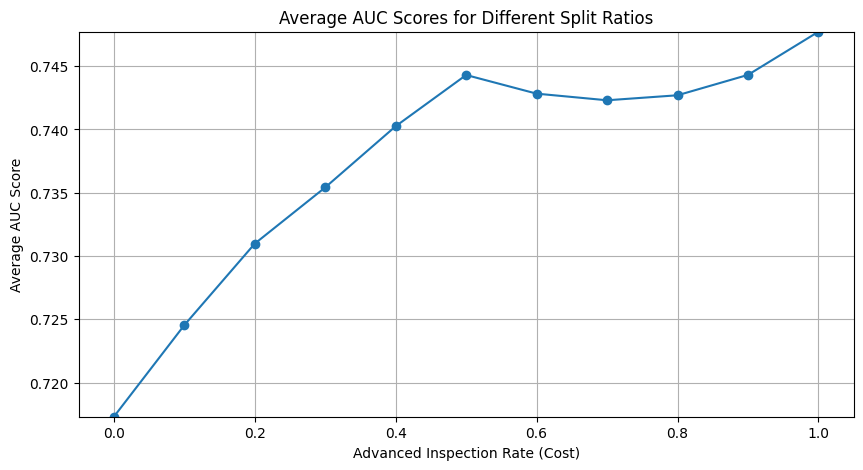

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import load

# 설치된 모듈 경로로 이동하기
%cd /home/iai/son/heo_jun/RF_new/recipe1/rf_module

# 모듈 함수 불러오기
from split_and_predict_uncertainty import split_and_predict_uncertainty
from train_teacher import train_teacher
from train_student import train_student
from test_predict import test_predict


random_states = range(1, 31)

# Define the split ratios
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Create an array to store the AUC scores for each random_state and split_ratio
auc_scores = np.zeros((len(random_states), len(split_ratios)))

data=pd.read_csv('/home/iai/son/activeinspection/data/active_whole.csv')
data_X=data.drop(['0.1'],axis=1)
data_y=data['0.1']

auc_score30_split_Baseline=[]
auc_score30_split_ad_BL=[]

# Loop through the random_states
for i, random_state in enumerate(random_states):
    # Build the models
    train_X,test_X,train_y,test_y=train_test_split(data_X,data_y,test_size=0.5,shuffle=True,stratify=data_y,random_state=random_state)
    test_stage_features=['0','1','2','3','4','5','6','7']
    random_forest_basic = train_student(train_y)
    random_forest_ad = train_teacher(train_y)

    # Fit the models
    random_forest_ad=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/advance_model_recipe1/advancemodel_randomstate{}'.format(i))
    # Train a regressor model
    train_X_new = train_X[test_stage_features]
    random_forest_basic=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/basic_model_recipe1/basicmodel_randomstate{}'.format(i))
    
    test_data=pd.concat([test_X,test_y],axis=1)
    test_X_new=test_X[test_stage_features]
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    y_predictions = test_predict(random_forest_basic,test_X_new)
    uncertainty_scores = [calculate_biased_margin(y_pred, fr) for y_pred in y_predictions]

    test_data['predictions'] = y_predictions
    test_data['uncertainty_scores'] = uncertainty_scores

# Sorting the DataFrame based on the uncertainty scores in ascending order
    test_data = test_data.sort_values(by='uncertainty_scores', ascending=False)

    test_y=test_data['0.1']
    
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, random_forest_ad, test_y, split_ratio)
        auc_scores[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Baseline model: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_baseline_biased_margin = auc_scores.mean(axis=0)

# Plot the average AUC scores
plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_baseline_biased_margin, marker='o')
plt.title('Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_baseline_biased_margin), max(average_auc_scores_baseline_biased_margin))
plt.grid()
plt.show()


In [2]:
import numpy as np
# Convert the lists to numpy arrays
auc_score30_split_Baseline_array = np.array(auc_score30_split_Baseline)
auc_score30_split_ad_BL_array = np.array(auc_score30_split_ad_BL)

# Calculate average and standard deviation for baseline model
baseline_avg = auc_score30_split_Baseline_array.mean()
baseline_std = auc_score30_split_Baseline_array.std()

# Calculate average and standard deviation for advance model
advance_avg = auc_score30_split_ad_BL_array.mean()
advance_std = auc_score30_split_ad_BL_array.std()

# Print the results
print("Baseline Model - Average AUC over 30 runs: ", baseline_avg)
print("Baseline Model - Standard Deviation of AUC over 30 runs: ", baseline_std)

print("\nAdvance Model - Average AUC over 30 runs: ", advance_avg)
print("Advance Model - Standard Deviation of AUC over 30 runs: ", advance_std)

Baseline Model - Average AUC over 30 runs:  0.717305644565762
Baseline Model - Standard Deviation of AUC over 30 runs:  0.027206555550528557

Advance Model - Average AUC over 30 runs:  0.7477177947886171
Advance Model - Standard Deviation of AUC over 30 runs:  0.0286538310788744


In [3]:
average_auc_scores_baseline_biased_margin

array([0.71730564, 0.72454127, 0.73097992, 0.73542099, 0.74025355,
       0.74429836, 0.74282623, 0.7423026 , 0.74269762, 0.74430796,
       0.74771779])

## VM- baised margin

/home/iai/son/heo_jun/RF_new/recipe1/rf_module
Random State가  1  일 때  Baseline model:  0.6980909783210697
Random State가  1  일 때  Advance model:  0.731744253896669
Random State가  2  일 때  Baseline model:  0.6968918130390062
Random State가  2  일 때  Advance model:  0.7112076212516814
Random State가  3  일 때  Baseline model:  0.7272047333649813
Random State가  3  일 때  Advance model:  0.7537359561674183
Random State가  4  일 때  Baseline model:  0.6718366761610888
Random State가  4  일 때  Advance model:  0.6938469222248596
Random State가  5  일 때  Baseline model:  0.6784840078328982
Random State가  5  일 때  Advance model:  0.7368388519661366
Random State가  6  일 때  Baseline model:  0.7197600185932431
Random State가  6  일 때  Advance model:  0.7744382466967323
Random State가  7  일 때  Baseline model:  0.7302446791676557
Random State가  7  일 때  Advance model:  0.7496526129440619
Random State가  8  일 때  Baseline model:  0.736542151277791
Random State가  8  일 때  Advance model:  0.7355049351214495
Random State가  9  일

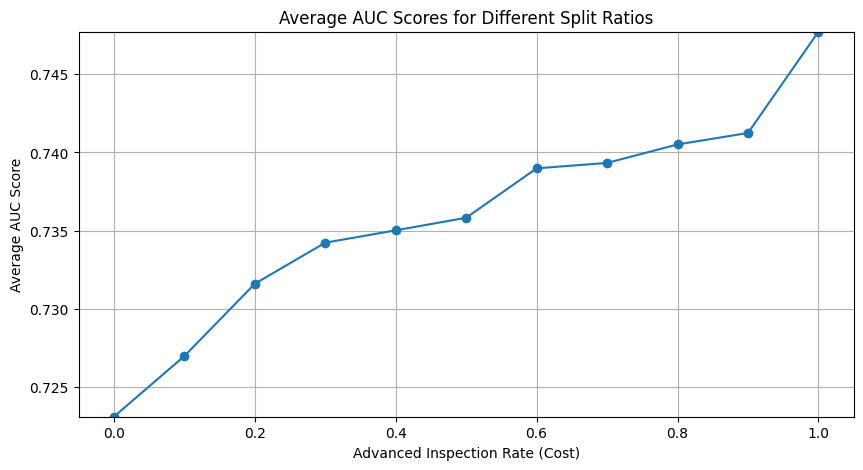

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import load

# 설치된 모듈 경로로 이동하기
%cd /home/iai/son/heo_jun/RF_new/recipe1/rf_module

# 모듈 함수 불러오기
from split_and_predict_uncertainty import split_and_predict_uncertainty
from test_predict_vm import test_predict_vm


random_states = range(1, 31)
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
auc_scores = np.zeros((len(random_states), len(split_ratios)))

data=pd.read_csv('/home/iai/son/activeinspection/data/active_whole.csv')
data_X=data.drop(['0.1'],axis=1)
data_y=data['0.1']

test_stage_features=['0','1','2','3','4','5','6','7']

auc_score30_split_Baseline=[]
auc_score30_split_ad_BL=[]

# Loop through the random_states
for i, random_state in enumerate(random_states):
    # Build the models
    train_X,test_X,train_y,test_y=train_test_split(data_X,data_y,test_size=0.5,shuffle=True,stratify=data_y,random_state=random_state)

    test_data=pd.concat([test_X,test_y],axis=1)
    random_forest_ad=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/advance_model_recipe1/advancemodel_randomstate{}'.format(i))

    # 가상계측 변수
    test_X_new=pd.read_csv('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/vm_dataset/virtual_dataset_randomstate{}.csv'.format(i))
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    y_predictions = test_predict_vm(random_forest_ad,test_X_new)
    uncertainty_scores = [calculate_biased_margin(y_pred, fr) for y_pred in y_predictions]

    test_data['predictions'] = y_predictions
    test_data['uncertainty_scores'] = uncertainty_scores

# Sorting the DataFrame based on the uncertainty scores in ascending order
    test_data = test_data.sort_values(by='uncertainty_scores', ascending=False)

    test_y=test_data['0.1']
    
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, random_forest_ad, test_y, split_ratio)
        auc_scores[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Baseline model: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores
average_auc_scores_VM_biased_margin = auc_scores.mean(axis=0)


# Plot the average AUC scores
plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_VM_biased_margin, marker='o')
plt.title('Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_VM_biased_margin), max(average_auc_scores_VM_biased_margin))
plt.grid()
plt.show()

In [6]:
import numpy as np
# Convert the lists to numpy arrays
auc_score30_split_Baseline_array = np.array(auc_score30_split_Baseline)
auc_score30_split_ad_BL_array = np.array(auc_score30_split_ad_BL)

# Calculate average and standard deviation for baseline model
baseline_avg = auc_score30_split_Baseline_array.mean()
baseline_std = auc_score30_split_Baseline_array.std()

# Calculate average and standard deviation for advance model
advance_avg = auc_score30_split_ad_BL_array.mean()
advance_std = auc_score30_split_ad_BL_array.std()

# Print the results
print("Baseline(vm) Model - Average AUC over 30 runs: ", baseline_avg)
print("Baseline(vm) Model - Standard Deviation of AUC over 30 runs: ", baseline_std)

print("\nAdvance Model - Average AUC over 30 runs: ", advance_avg)
print("Advance Model - Standard Deviation of AUC over 30 runs: ", advance_std)

Baseline(vm) Model - Average AUC over 30 runs:  0.7230965002505472
Baseline(vm) Model - Standard Deviation of AUC over 30 runs:  0.027680770184897535

Advance Model - Average AUC over 30 runs:  0.7477177947886171
Advance Model - Standard Deviation of AUC over 30 runs:  0.0286538310788744


In [7]:
average_auc_scores_VM_biased_margin

array([0.7230965 , 0.72697273, 0.73159821, 0.73422719, 0.73501612,
       0.73581882, 0.73898115, 0.73932714, 0.74050887, 0.74124173,
       0.74771779])

## KD - baised margin

/home/iai/son/heo_jun/RF_new/recipe1/rf_module
Random State가  1  일 때  Baseline model:  0.737632526307461
Random State가  1  일 때  Advance model:  0.731744253896669
Random State가  2  일 때  Baseline model:  0.7789357346309043
Random State가  2  일 때  Advance model:  0.7112076212516814
Random State가  3  일 때  Baseline model:  0.747149200886146
Random State가  3  일 때  Advance model:  0.7537359561674183
Random State가  4  일 때  Baseline model:  0.719954110293536
Random State가  4  일 때  Advance model:  0.6938469222248596
Random State가  5  일 때  Baseline model:  0.7165519424005063
Random State가  5  일 때  Advance model:  0.7368388519661366
Random State가  6  일 때  Baseline model:  0.7383075203734473
Random State가  6  일 때  Advance model:  0.7744382466967323
Random State가  7  일 때  Baseline model:  0.7492903908537067
Random State가  7  일 때  Advance model:  0.7496526129440619
Random State가  8  일 때  Baseline model:  0.7527964039876571
Random State가  8  일 때  Advance model:  0.7355049351214495
Random State가  9  일 때

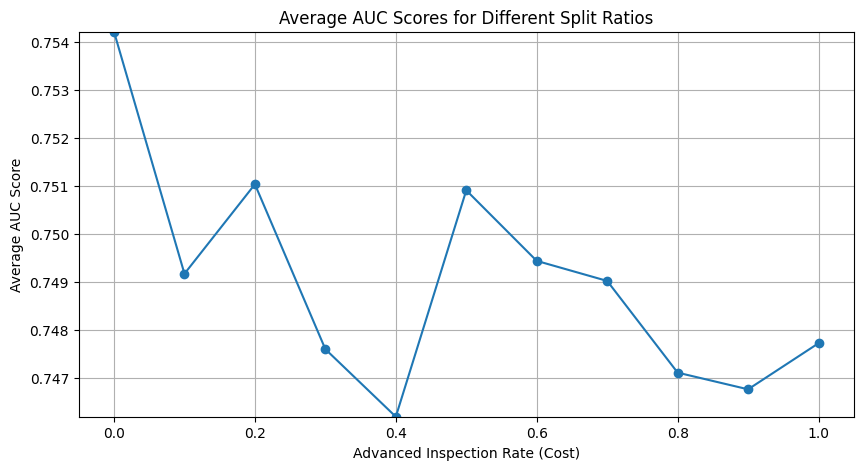

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from joblib import load

# 설치된 모듈 경로로 이동하기
%cd /home/iai/son/heo_jun/RF_new/recipe1/rf_module

# 모듈 함수 불러오기
from split_and_predict_uncertainty import split_and_predict_uncertainty
from test_predict_kd import test_predict_kd



random_states = range(1, 31)

# Define the split ratios
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Create an array to store the AUC scores for each random_state and split_ratio
auc_scores = np.zeros((len(random_states), len(split_ratios)))

data=pd.read_csv('/home/iai/son/activeinspection/data/active_whole.csv')
data_X=data.drop(['0.1'],axis=1)
data_y=data['0.1']

auc_score30_split_Baseline=[]
auc_score30_split_ad_BL=[]
# Loop through the random_states
for i, random_state in enumerate(random_states):
    train_X,test_X,train_y,test_y=train_test_split(data_X,data_y,test_size=0.5,shuffle=True,stratify=data_y,random_state=random_state)
    

    random_forest_ad=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/advance_model_recipe1/advancemodel_randomstate{}'.format(i))
    random_forest_basic=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/basic_model_recipe1/basicmodel_randomstate{}'.format(i))

    # Create DataFrame for training probability
    train_prob = pd.DataFrame()
    train_prob['prob'] = random_forest_ad.predict_proba(train_X)[:, 1]

    # Train a regressor model
    test_stage_features = ['0', '1', '2', '3', '4', '5', '6', '7']
    train_X_new = train_X[test_stage_features]
    random_forest_r=load('/home/iai/son/heo_jun/RF_new/recipe1/randomforest/kd_model_recipe1/kdmodel_randomstate{}'.format(i))

    test_data=pd.concat([test_X,test_y],axis=1)
    
    test_X_new=test_X[test_stage_features]
    test_y=test_data['0.1']
    fr = np.sum(test_y) / len(test_y)

# Biased margin을 계산하여 uncertainty score로 사용
    def calculate_biased_margin(y_pred, fr):
        if y_pred <= fr:
            return y_pred / fr
        else:
            return (1 - y_pred) / (1 - fr)

# 각각의 예측에 대해 biased margin을 계산
    y_predictions = test_predict_kd(random_forest_r,test_X_new)
    uncertainty_scores = [calculate_biased_margin(y_pred, fr) for y_pred in y_predictions]

    test_data['predictions'] = y_predictions
    test_data['uncertainty_scores'] = uncertainty_scores

# Sorting the DataFrame based on the uncertainty scores in ascending order
    test_data = test_data.sort_values(by='uncertainty_scores', ascending=False)

    test_y=test_data['0.1']


    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, random_forest_ad, test_y, split_ratio)
        auc_scores[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Baseline model: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)

# Calculate the average AUC scores
average_auc_scores_KD_biased_margin = auc_scores.mean(axis=0)

# Plot the average AUC scores
plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_biased_margin, marker='o')
plt.title('Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_biased_margin), max(average_auc_scores_KD_biased_margin))
plt.grid()
plt.show()

In [12]:
import numpy as np
# Convert the lists to numpy arrays
auc_score30_split_Baseline_array = np.array(auc_score30_split_Baseline)
auc_score30_split_ad_BL_array = np.array(auc_score30_split_ad_BL)

# Calculate average and standard deviation for baseline model
baseline_avg = auc_score30_split_Baseline_array.mean()
baseline_std = auc_score30_split_Baseline_array.std()

# Calculate average and standard deviation for advance model
advance_avg = auc_score30_split_ad_BL_array.mean()
advance_std = auc_score30_split_ad_BL_array.std()

# Print the results
print("Baseline(KD) Model - Average AUC over 30 runs: ", baseline_avg)
print("Baseline(KD) Model - Standard Deviation of AUC over 30 runs: ", baseline_std)

print("\nAdvance Model - Average AUC over 30 runs: ", advance_avg)
print("Advance Model - Standard Deviation of AUC over 30 runs: ", advance_std)

Baseline(KD) Model - Average AUC over 30 runs:  0.754204331170715
Baseline(KD) Model - Standard Deviation of AUC over 30 runs:  0.02196482395348775

Advance Model - Average AUC over 30 runs:  0.7477177947886171
Advance Model - Standard Deviation of AUC over 30 runs:  0.0286538310788744


In [13]:
average_auc_scores_KD_biased_margin

array([0.75420433, 0.74916429, 0.75102794, 0.74759355, 0.74618698,
       0.75090185, 0.74943219, 0.74901475, 0.74710507, 0.74675756,
       0.74771779])